In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

"""
读取数据
Parameters:
    fileName - 文件名
Returns:
    dataMat - 数据矩阵
    labelMat - 数据标签
"""
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat

"""
数据可视化
Parameters:
    dataMat - 数据矩阵
    labelMat - 数据标签
Returns:
    无
"""
def showDataSet(dataMat, labelMat):
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1]) #负样本散点图
    plt.show()

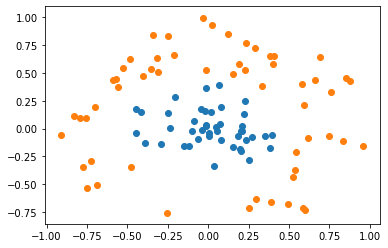

In [2]:
dataArr,labelArr = loadDataSet('testSetRBF.txt')                        #加载训练集
showDataSet(dataArr, labelArr)

In [4]:
"""
数据结构，维护所有需要操作的值
Parameters：
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
    kTup - 包含核函数信息的元组,第一个参数存放核函数类别，第二个参数存放必要的核函数需要用到的参数
"""
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0   
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
        self.K = np.mat(np.zeros((self.m,self.m)))        #初始化核K
        for i in range(self.m):                            #计算所有数据的核K
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)
 
"""
通过核函数将数据转换更高维的空间
Parameters：
    X - 数据矩阵
    A - 单个数据的向量
    kTup - 包含核函数信息的元组
Returns:
    K - 计算的核K
"""
def kernelTrans(X, A, kTup):
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin': K = X * A.T                       #线性核函数,只进行内积。
    elif kTup[0] == 'rbf':                                 #高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2))                     #计算高斯核K
    else: raise NameError('核函数无法识别')
    return K                                             #返回计算的核K

"""
读取数据
Parameters:
    fileName - 文件名
Returns:
    dataMat - 数据矩阵
    labelMat - 数据标签
"""
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat
 
"""
计算误差
Parameters：
    oS - 数据结构
    k - 标号为k的数据
Returns:
    Ek - 标号为k的数据误差
"""
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
 
"""
函数说明:随机选择alpha_j的索引值

Parameters:
    i - alpha_i的索引值
    m - alpha参数个数
Returns:
    j - alpha_j的索引值
"""
def selectJrand(i, m):
    j = i                                 #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j
 
"""
内循环启发方式2
Parameters：
    i - 标号为i的数据的索引值
    oS - 数据结构
    Ei - 标号为i的数据误差
Returns:
    j, maxK - 标号为j或maxK的数据的索引值
    Ej - 标号为j的数据误差
"""
def selectJ(i, oS, Ei):
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej
 
"""
计算Ek,并更新误差缓存
Parameters：
    oS - 数据结构
    k - 标号为k的数据的索引值
Returns:
    无
"""
def updateEk(oS, k):
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存
 
"""
修剪alpha_j
Parameters:
    aj - alpha_j的值
    H - alpha上限
    L - alpha下限
Returns:
    aj - 修剪后的alpah_j的值
"""
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj
 
"""
优化的SMO算法
Parameters：
    i - 标号为i的数据的索引值
    oS - 数据结构
Returns:
    1 - 有任意一对alpha值发生变化
    0 - 没有任意一对alpha值发生变化或变化太小
"""
def innerL(i, oS):
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0
 
"""
完整的线性SMO算法
Parameters：
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
    maxIter - 最大迭代次数
    kTup - 包含核函数信息的元组
Returns:
    oS.b - SMO算法计算的b
    oS.alphas - SMO算法计算的alphas
"""
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup = ('lin',0)):
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler, kTup)                #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集                           
            for i in range(oS.m):       
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True 
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas
 
"""
测试函数
Parameters:
    k1 - 使用高斯核函数的时候表示到达率
Returns:
    无
"""
def testRbf(k1 = 1.3):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')                        #加载训练集
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 100, ('rbf', k1))        #根据训练集计算b和alphas
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]                                        #获得支持向量
    sVs = datMat[svInd]                                                     
    labelSV = labelMat[svInd];
    print("支持向量个数:%d" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                #计算各个点的核
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b     #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("训练集错误率: %.2f%%" % ((float(errorCount)/m)*100))             #打印错误率
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')                         #加载测试集
    errorCount = 0
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()         
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                 #计算各个点的核           
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b         #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("测试集错误率: %.2f%%" % ((float(errorCount)/m)*100))             #打印错误率
 
"""
数据可视化
Parameters:
    dataMat - 数据矩阵
    labelMat - 数据标签
Returns:
    无
"""
def showDataSet(dataMat, labelMat):
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1]) #负样本散点图
    plt.show()

In [5]:
testRbf()

全样本遍历:第0次迭代 样本:0, alpha优化次数:1
全样本遍历:第0次迭代 样本:1, alpha优化次数:1
全样本遍历:第0次迭代 样本:2, alpha优化次数:2
全样本遍历:第0次迭代 样本:3, alpha优化次数:3
全样本遍历:第0次迭代 样本:4, alpha优化次数:3
全样本遍历:第0次迭代 样本:5, alpha优化次数:4
全样本遍历:第0次迭代 样本:6, alpha优化次数:5
全样本遍历:第0次迭代 样本:7, alpha优化次数:5
全样本遍历:第0次迭代 样本:8, alpha优化次数:6
全样本遍历:第0次迭代 样本:9, alpha优化次数:6
全样本遍历:第0次迭代 样本:10, alpha优化次数:7
全样本遍历:第0次迭代 样本:11, alpha优化次数:7
全样本遍历:第0次迭代 样本:12, alpha优化次数:7
全样本遍历:第0次迭代 样本:13, alpha优化次数:8
全样本遍历:第0次迭代 样本:14, alpha优化次数:9
全样本遍历:第0次迭代 样本:15, alpha优化次数:10
全样本遍历:第0次迭代 样本:16, alpha优化次数:11
全样本遍历:第0次迭代 样本:17, alpha优化次数:12
全样本遍历:第0次迭代 样本:18, alpha优化次数:12
全样本遍历:第0次迭代 样本:19, alpha优化次数:12
全样本遍历:第0次迭代 样本:20, alpha优化次数:12
全样本遍历:第0次迭代 样本:21, alpha优化次数:13
alpha_j变化太小
全样本遍历:第0次迭代 样本:22, alpha优化次数:13
alpha_j变化太小
全样本遍历:第0次迭代 样本:23, alpha优化次数:13
全样本遍历:第0次迭代 样本:24, alpha优化次数:13
全样本遍历:第0次迭代 样本:25, alpha优化次数:13
全样本遍历:第0次迭代 样本:26, alpha优化次数:14
全样本遍历:第0次迭代 样本:27, alpha优化次数:15
全样本遍历:第0次迭代 样本:28, alpha优化次数:16
全样本遍历:第0次迭代 样本:29, alpha优化次数:17
全样本遍历:第0次迭代 样本:30, alpha优化次数:17
全样本遍历:第0次

训练集错误率: 0.00%
测试集错误率: 8.00%
